In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

import warnings
from optuna.logging import set_verbosity
from sklearn.preprocessing import StandardScaler

In [43]:
train_df = pd.read_csv('mai-ml-lab-2/train.csv')
test_df = pd.read_csv('mai-ml-lab-2/test.csv')

# Вспомогательные функции

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def plot_correlation(df, feature_x, feature_y):
    plt.figure(figsize=(10, 6))
    sns.regplot(x=feature_x, y=feature_y, data=df, scatter=True, line_kws={"color": "red"})
    plt.title(f'Связь между {feature_x} и {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.grid(alpha=0.3)
    plt.show()

def visualize_distributions(df, columns=None, plot_type='hist'):
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    total = len(columns)
    plt.figure(figsize=(12, total * 4))

    for idx, column in enumerate(columns, start=1):
        plt.subplot(total, 1, idx)
        if plot_type == 'hist':
            sns.histplot(data=df, x=column, kde=True, bins=30, color='skyblue')
            plt.title(f'Гистограмма переменной {column}')
        elif plot_type == 'kde':
            sns.kdeplot(data=df[column], fill=True, color='purple')
            plt.title(f'Плотность распределения (KDE) {column}')
        elif plot_type == 'box':
            sns.boxplot(x=df[column], color='orange')
            plt.title(f'Диаграмма размаха {column}')
        else:
            raise ValueError(f"Неизвестный формат графика: {plot_type}")

        plt.xlabel(column)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

def compare_actual_vs_predicted(true_vals, predicted_vals):
    plt.figure(figsize=(10, 7))
    plt.scatter(true_vals, predicted_vals, alpha=0.6, color='blue', label='Модель')
    plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], color='red', linewidth=2, label='Идеальное соответствие')
    plt.xlabel('Истинные значения')
    plt.ylabel('Прогнозы')
    plt.title('Сопоставление предсказанных и настоящих значений')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# Разведочный анализ данных

In [45]:
print(train_df.head())
print(test_df.head())

   id   age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0  55.0       150.0        50.0       73.0             0.8   
1   1  50.0       160.0        60.0       79.6             1.0   
2   2  55.0       145.0        50.0       73.0             1.2   
3   3  40.0       175.0        80.0       83.2             0.9   
4   4  30.0       170.0        70.0       79.5             1.2   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...   HDL    LDL  \
0              1.0            1.0             1.0     122.0  ...  62.0  113.0   
1              0.8            1.0             1.0     124.0  ...  74.0  112.0   
2              1.2            1.0             1.0     110.0  ...  66.0  123.0   
3              1.0            1.0             1.0      99.0  ...  38.0  114.0   
4              1.2            1.0             1.0     119.0  ...  49.0  148.0   

   hemoglobin  Urine protein  serum creatinine   AST   ALT   Gtp  \
0        12.0            1.0               0.6  

In [46]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   height(cm)           10000 non-null  float64
 3   weight(kg)           10000 non-null  float64
 4   waist(cm)            10000 non-null  float64
 5   eyesight(left)       10000 non-null  float64
 6   eyesight(right)      10000 non-null  float64
 7   hearing(left)        10000 non-null  float64
 8   hearing(right)       10000 non-null  float64
 9   systolic             10000 non-null  float64
 10  relaxation           10000 non-null  float64
 11  fasting blood sugar  10000 non-null  float64
 12  Cholesterol          10000 non-null  float64
 13  triglyceride         10000 non-null  float64
 14  HDL                  10000 non-null  float64
 15  LDL                  10000 non-null  

None

In [47]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64
id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL         

In [48]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


In [49]:
display(train_df.describe())
display(test_df.describe())

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,42.606000,164.672667,64.282000,80.323180,1.032727,1.025927,1.005533,1.004933,119.149467,...,57.535667,113.158533,14.510340,1.016533,0.866580,22.272667,20.874933,26.290200,0.139467,0.366600
std,4330.271354,10.415341,8.558684,10.973871,7.932701,0.312845,0.313488,0.074183,0.070067,11.167046,...,11.380739,18.442012,1.392921,0.157464,0.168492,6.324422,10.314009,20.431882,0.346444,0.481892
min,0.000000,20.000000,140.000000,35.000000,0.900000,0.100000,0.100000,1.000000,1.000000,82.000000,...,28.000000,41.000000,7.200000,1.000000,0.100000,9.000000,4.000000,6.000000,0.000000,0.000000
25%,3749.750000,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,110.000000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,7499.500000,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.000000,119.000000,...,56.000000,112.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,11249.250000,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.000000,128.000000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,14999.000000,80.000000,190.000000,120.000000,121.000000,9.900000,9.900000,2.000000,2.000000,190.000000,...,105.000000,193.000000,28.900000,5.000000,1.600000,324.000000,190.000000,566.000000,1.000000,1.000000


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,19999.50000,42.690000,164.737500,64.343000,80.355780,1.033340,1.030660,1.005300,1.00580,118.995400,...,102.987800,57.250900,113.571700,14.544950,1.015900,0.868460,22.26470,20.991600,26.748300,0.143400
std,2886.89568,10.476873,8.574436,11.110612,7.995454,0.300535,0.301209,0.072612,0.07594,11.021276,...,48.720228,11.407908,18.540033,1.391966,0.156364,0.167678,5.91117,10.474517,20.230123,0.350498
min,15000.00000,20.000000,140.000000,40.000000,58.000000,0.100000,0.100000,1.000000,1.00000,82.000000,...,20.000000,27.000000,40.000000,5.900000,1.000000,0.100000,9.00000,5.000000,6.000000,0.000000
25%,17499.75000,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.00000,110.000000,...,71.000000,49.000000,100.000000,13.500000,1.000000,0.800000,18.00000,14.000000,15.000000,0.000000
50%,19999.50000,40.000000,165.000000,65.000000,80.200000,1.000000,1.000000,1.000000,1.00000,119.000000,...,90.000000,56.000000,113.000000,14.700000,1.000000,0.900000,21.00000,18.000000,21.000000,0.000000
75%,22499.25000,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.00000,127.250000,...,121.000000,65.000000,126.000000,15.600000,1.000000,1.000000,25.00000,25.000000,31.000000,0.000000
max,24999.00000,80.000000,185.000000,110.000000,114.000000,9.900000,9.900000,2.000000,2.00000,170.000000,...,397.000000,103.000000,187.000000,19.300000,4.000000,2.500000,117.00000,215.000000,568.000000,1.000000


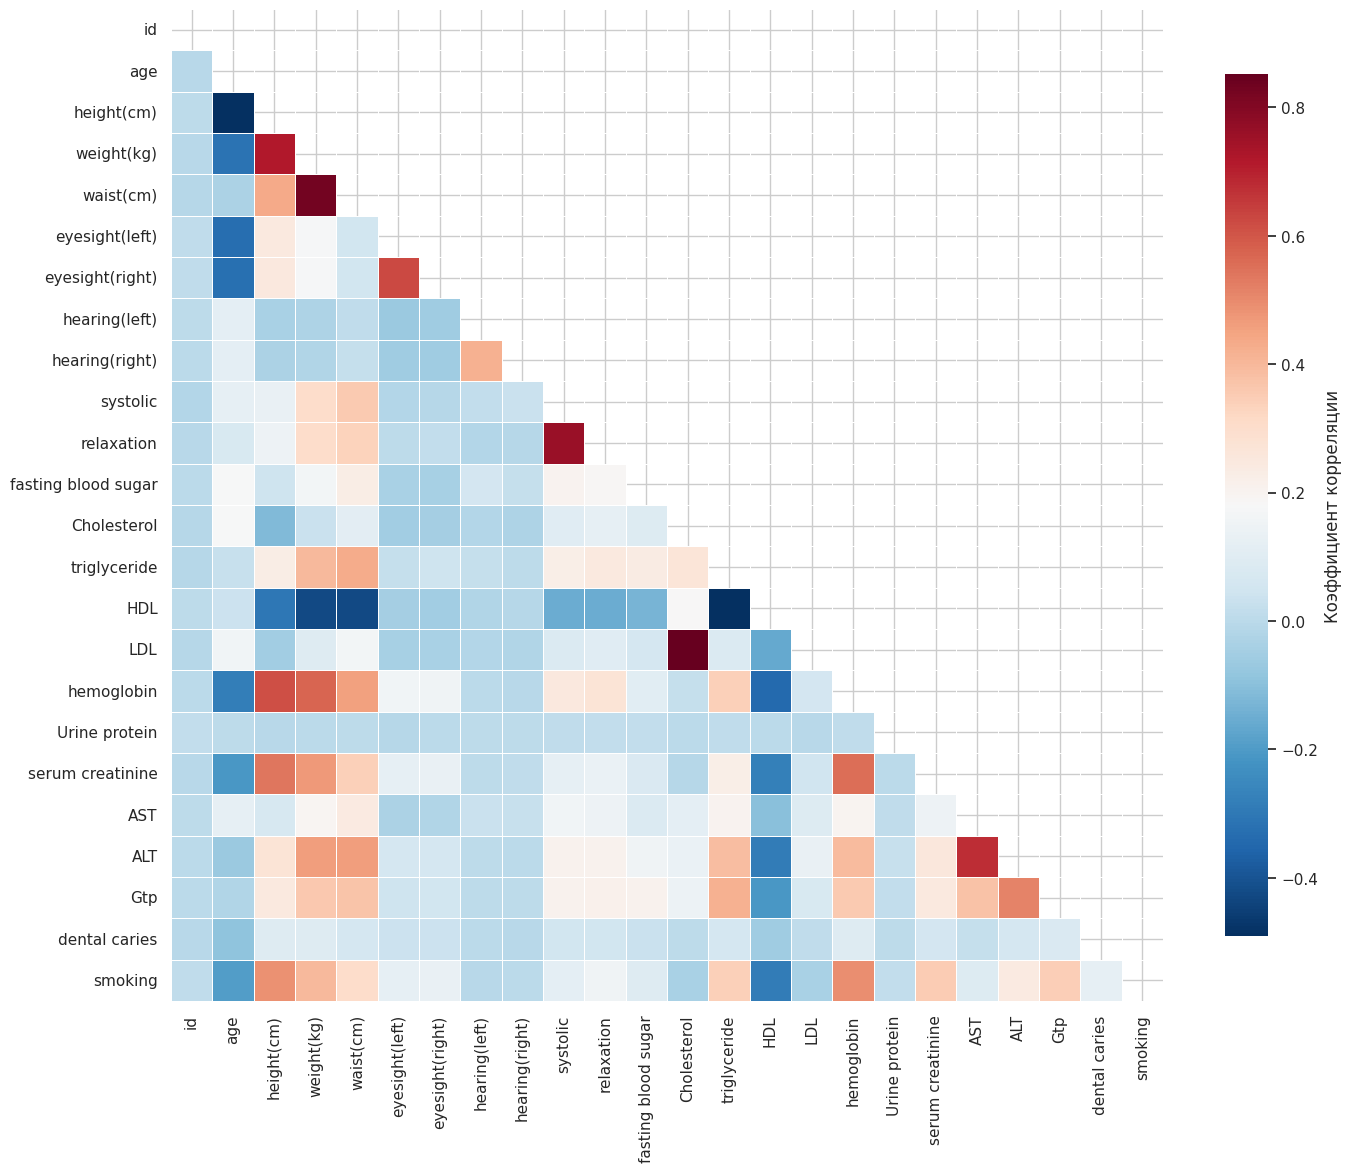

In [50]:
correlation_matrix = train_df.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            square=True,
            annot=False,
            fmt=".1f",
            cmap="RdBu_r",
            cbar_kws={"shrink": 0.8, "label": "Коэффициент корреляции"},
            linecolor='white',
            linewidths=0.5,
            mask=np.triu(np.ones_like(correlation_matrix, dtype=bool))
)
plt.show()

In [51]:
high_corr = correlation_matrix[(abs(correlation_matrix) >= 0.7) & (correlation_matrix != 1.0)].stack()

low_corr = correlation_matrix[(abs(correlation_matrix) <= 0.1)].stack()
print(high_corr)
print(low_corr[::100])

height(cm)   weight(kg)     0.716334
weight(kg)   height(cm)     0.716334
             waist(cm)      0.826307
waist(cm)    weight(kg)     0.826307
systolic     relaxation     0.758938
relaxation   systolic       0.758938
Cholesterol  LDL            0.852157
LDL          Cholesterol    0.852157
dtype: float64
id             age            -0.007935
hearing(left)  hemoglobin     -0.000296
LDL            triglyceride    0.083153
smoking        Cholesterol    -0.035048
dtype: float64


High correlation pairs:
height(cm) vs weight(kg)


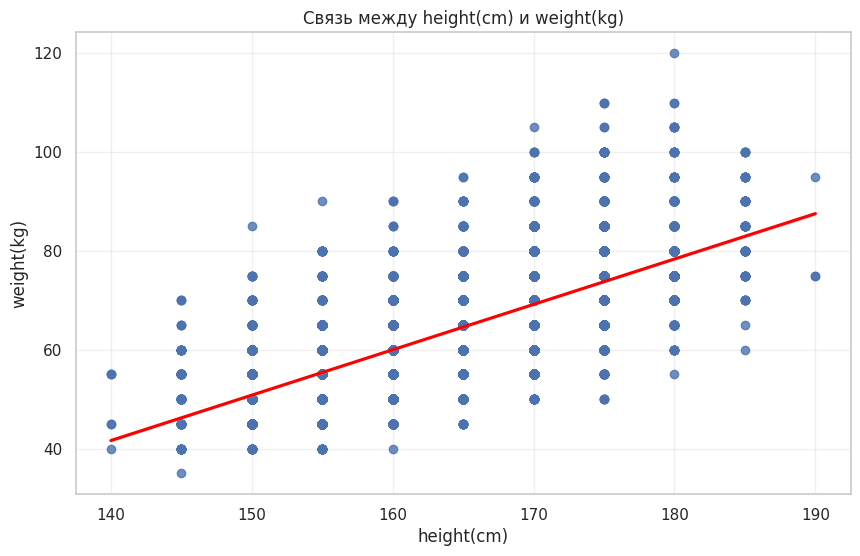

weight(kg) vs waist(cm)


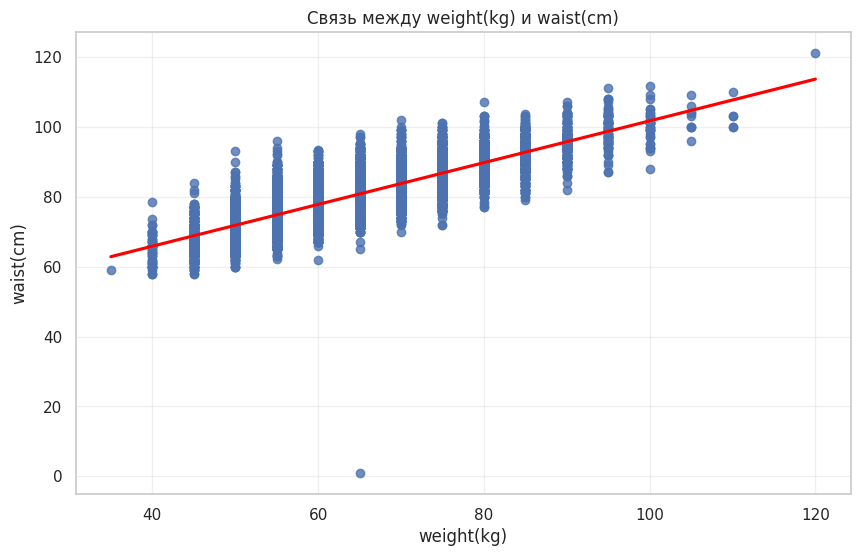

systolic vs relaxation


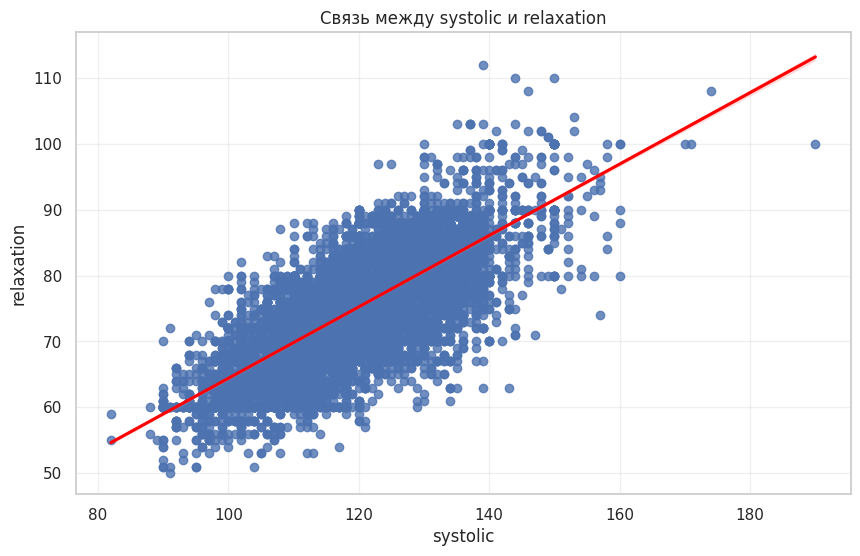

Cholesterol vs LDL


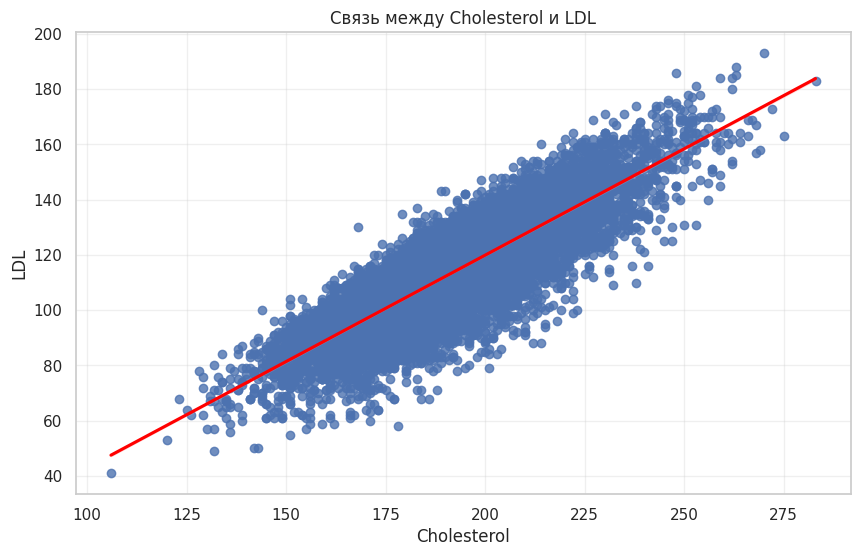


Low correlation pairs:
id vs age


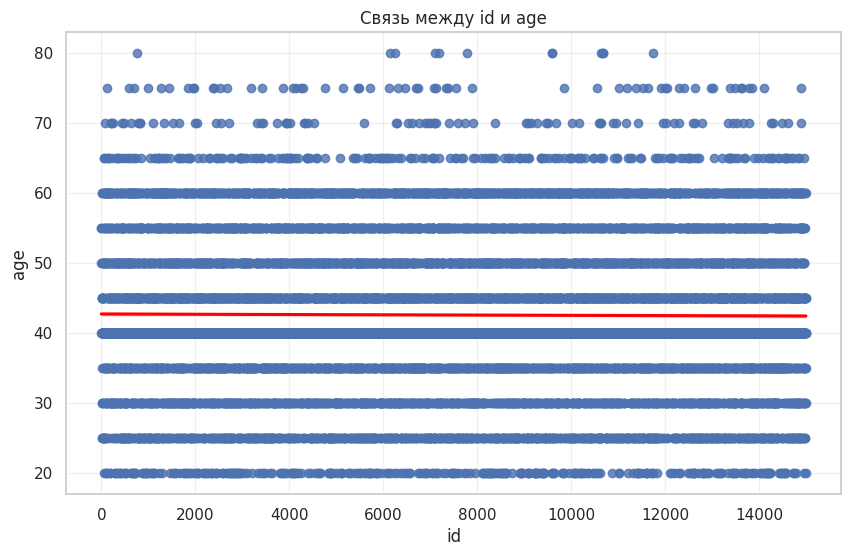

hearing(left) vs hemoglobin


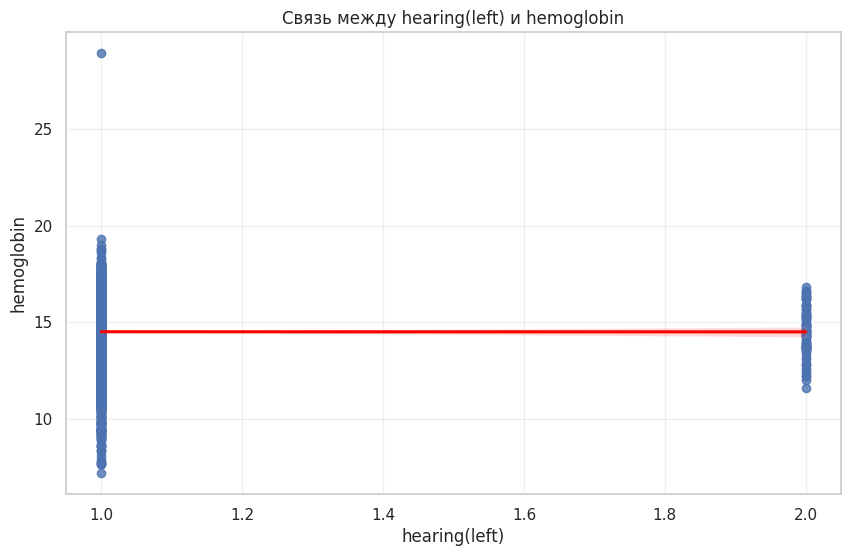

LDL vs triglyceride


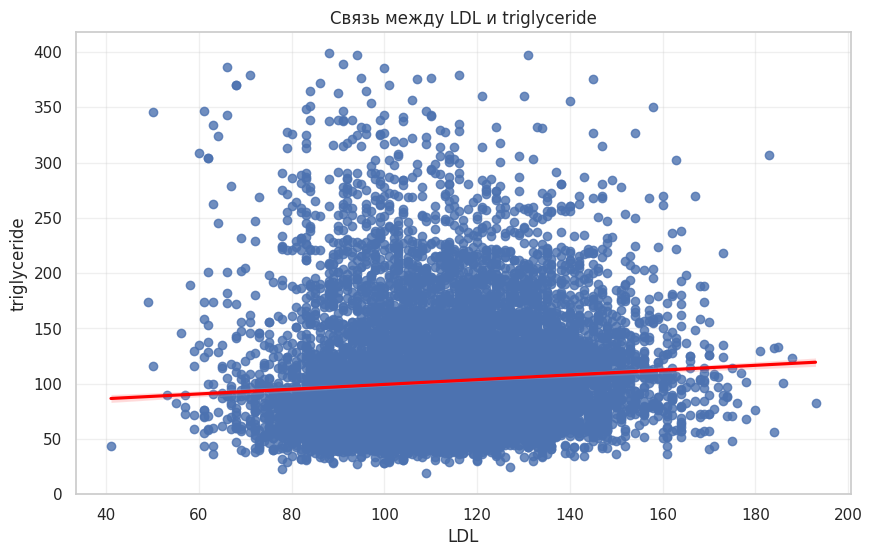

smoking vs Cholesterol


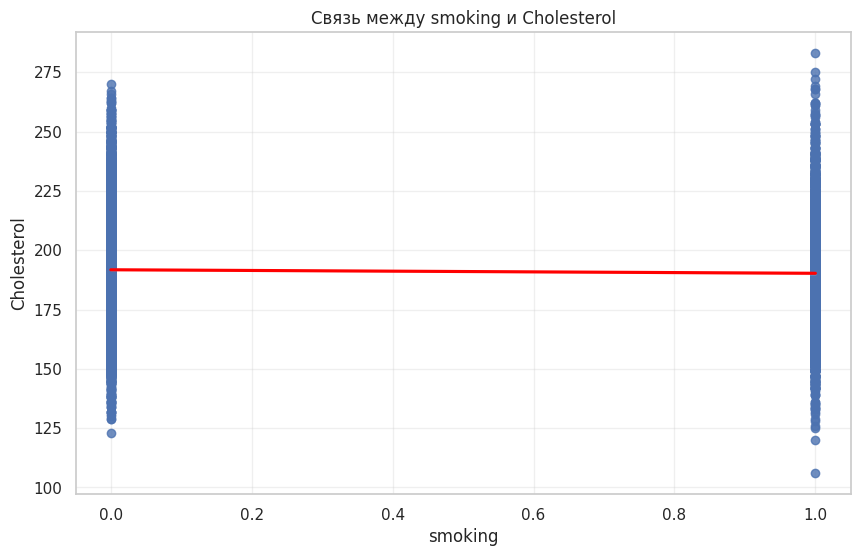

In [52]:
high_corr_pairs = correlation_matrix[
    (correlation_matrix.abs() >= 0.7) & (correlation_matrix.abs() < 1.0)
].stack().reset_index()
high_corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

low_corr_pairs = correlation_matrix[
    (correlation_matrix.abs() <= 0.1)
].stack().reset_index()
low_corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

def filter_unique_pairs(df):
    seen = set()
    unique = []
    for _, row in df.iterrows():
        a, b = row[0], row[1]
        if (b, a) not in seen and (a != b):
            seen.add((a, b))
            unique.append((a, b))
    return unique

high_pairs = filter_unique_pairs(high_corr_pairs)
low_pairs = filter_unique_pairs(low_corr_pairs[::100])

print("High correlation pairs:")
for x, y in high_pairs:
    print(f"{x} vs {y}")
    plot_correlation(train_df, x, y)

print("\nLow correlation pairs:")
for x, y in low_pairs:
    print(f"{x} vs {y}")
    plot_correlation(train_df, x, y)


In [53]:
train_df = train_df.drop(columns="id")

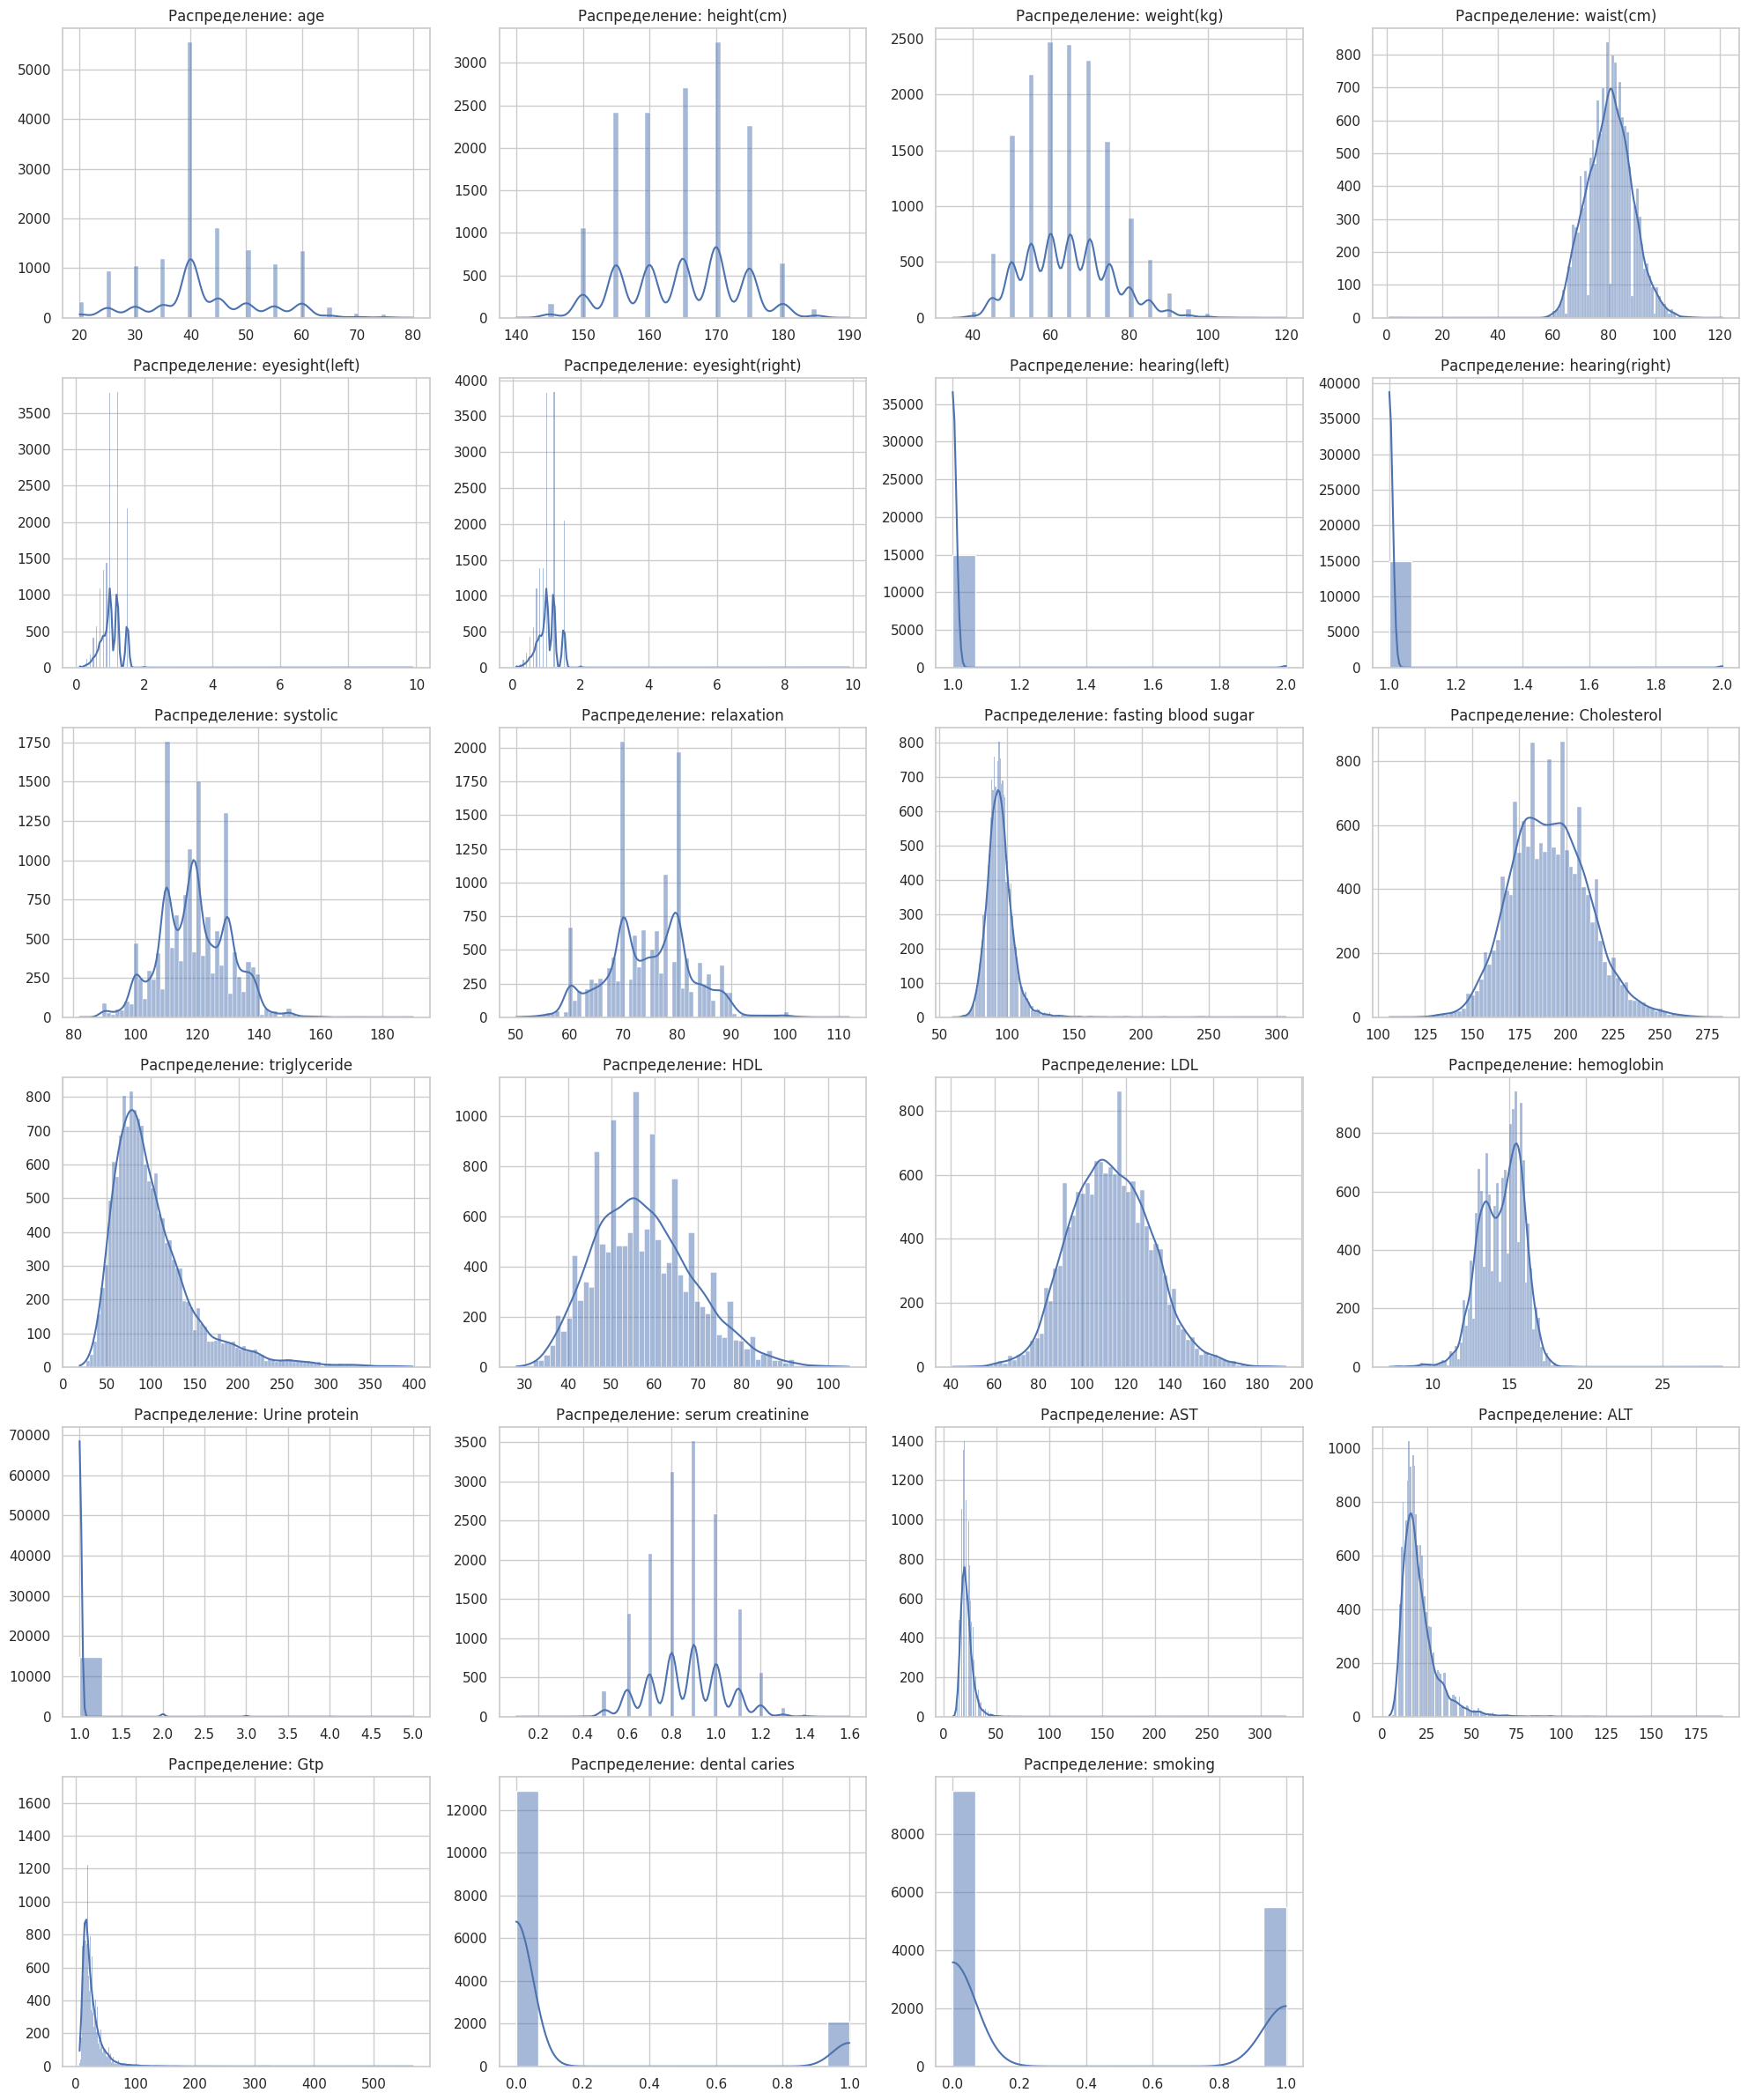

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

def visualize_features(df, max_columns=4, base_figsize=(20, 4)):
    total_features = df.shape[1]
    cols_per_row = min(max_columns, total_features)
    rows_needed = math.ceil(total_features / cols_per_row)

    plt.figure(figsize=(base_figsize[0], base_figsize[1] * rows_needed))

    for idx, feature in enumerate(df.columns, start=1):
        plt.subplot(rows_needed, cols_per_row, idx)

        if pd.api.types.is_numeric_dtype(df[feature]):
            sns.histplot(df[feature].dropna(), kde=True)
            plt.title(f'Распределение: {feature}')
        else:
            df[feature].value_counts().plot(kind='bar')
            plt.title(f'Категории: {feature}')

        plt.xlabel('')
        plt.ylabel('')
    
    plt.tight_layout()
    plt.show()

visualize_features(train_df)


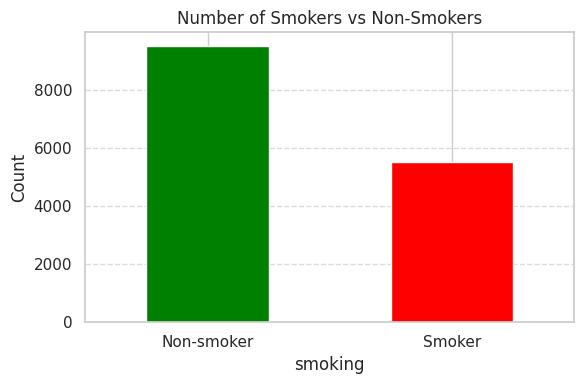

In [55]:
smoking_counts = train_df['smoking'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
smoking_counts.plot(kind='bar', color=['green', 'red'])
plt.xticks([0, 1], ['Non-smoker', 'Smoker'], rotation=0)
plt.ylabel('Count')
plt.title('Number of Smokers vs Non-Smokers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

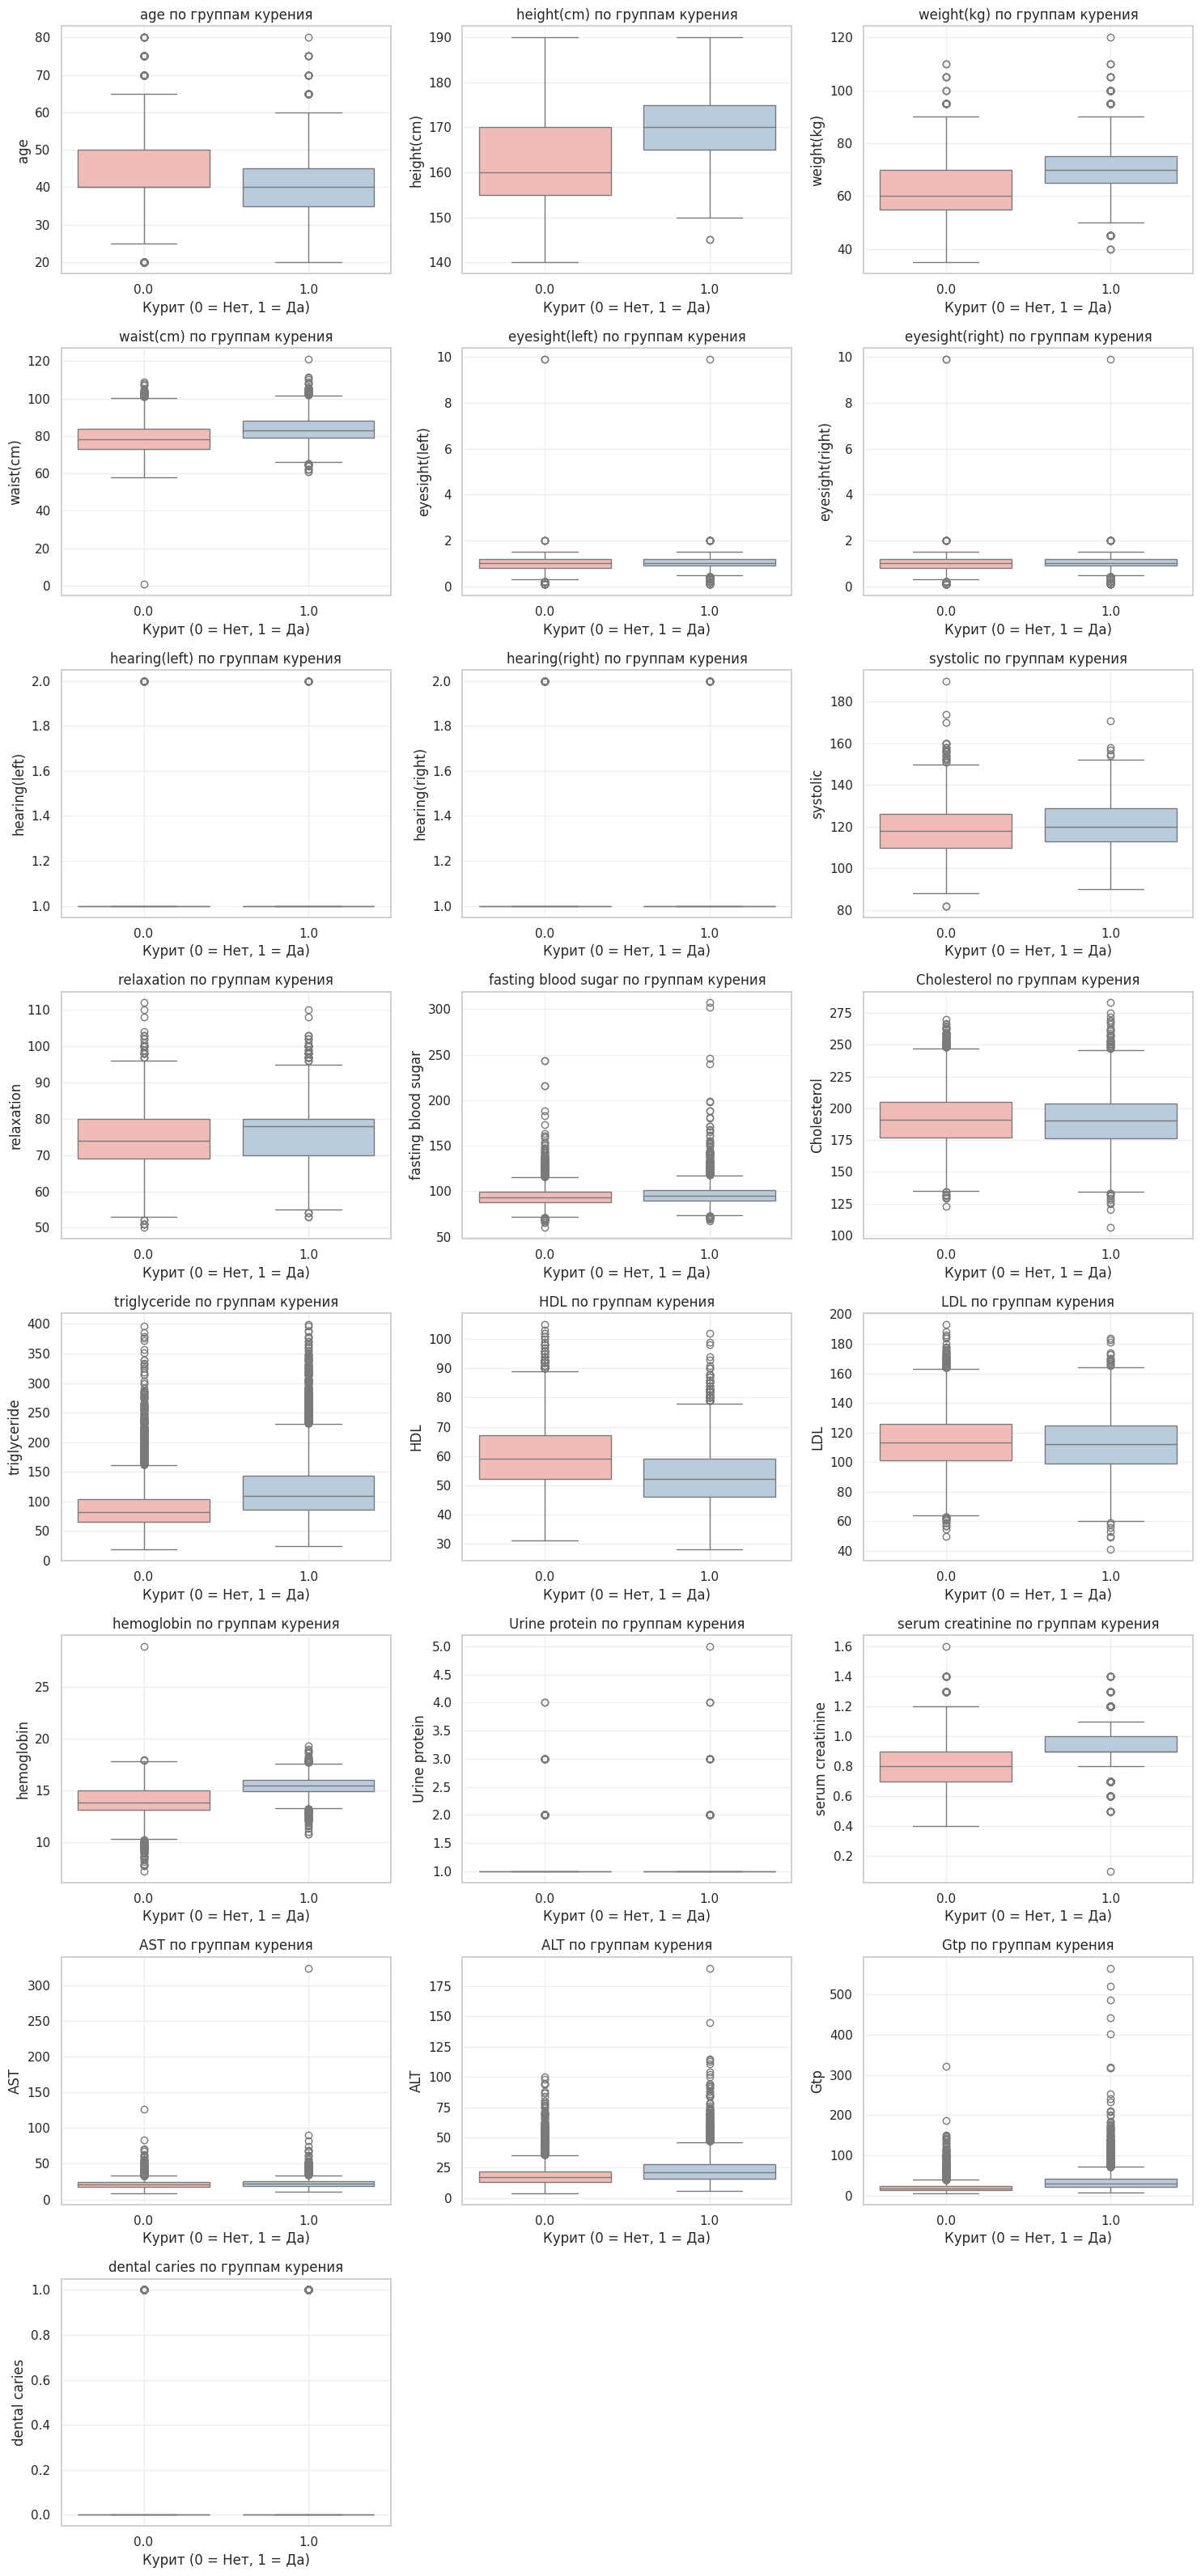

In [56]:

numeric_features = train_df.select_dtypes(include='number').drop(columns='smoking').columns

columns_per_row = 3
rows_required = -(-len(numeric_features) // columns_per_row) 

plt.figure(figsize=(columns_per_row * 5, rows_required * 4))

for idx, feature in enumerate(numeric_features, start=1):
    plt.subplot(rows_required, columns_per_row, idx)
    sns.boxplot(x='smoking', y=feature, data=train_df, palette='Pastel1')
    plt.title(f'{feature} по группам курения')
    plt.xlabel('Курит (0 = Нет, 1 = Да)')
    plt.ylabel(feature)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


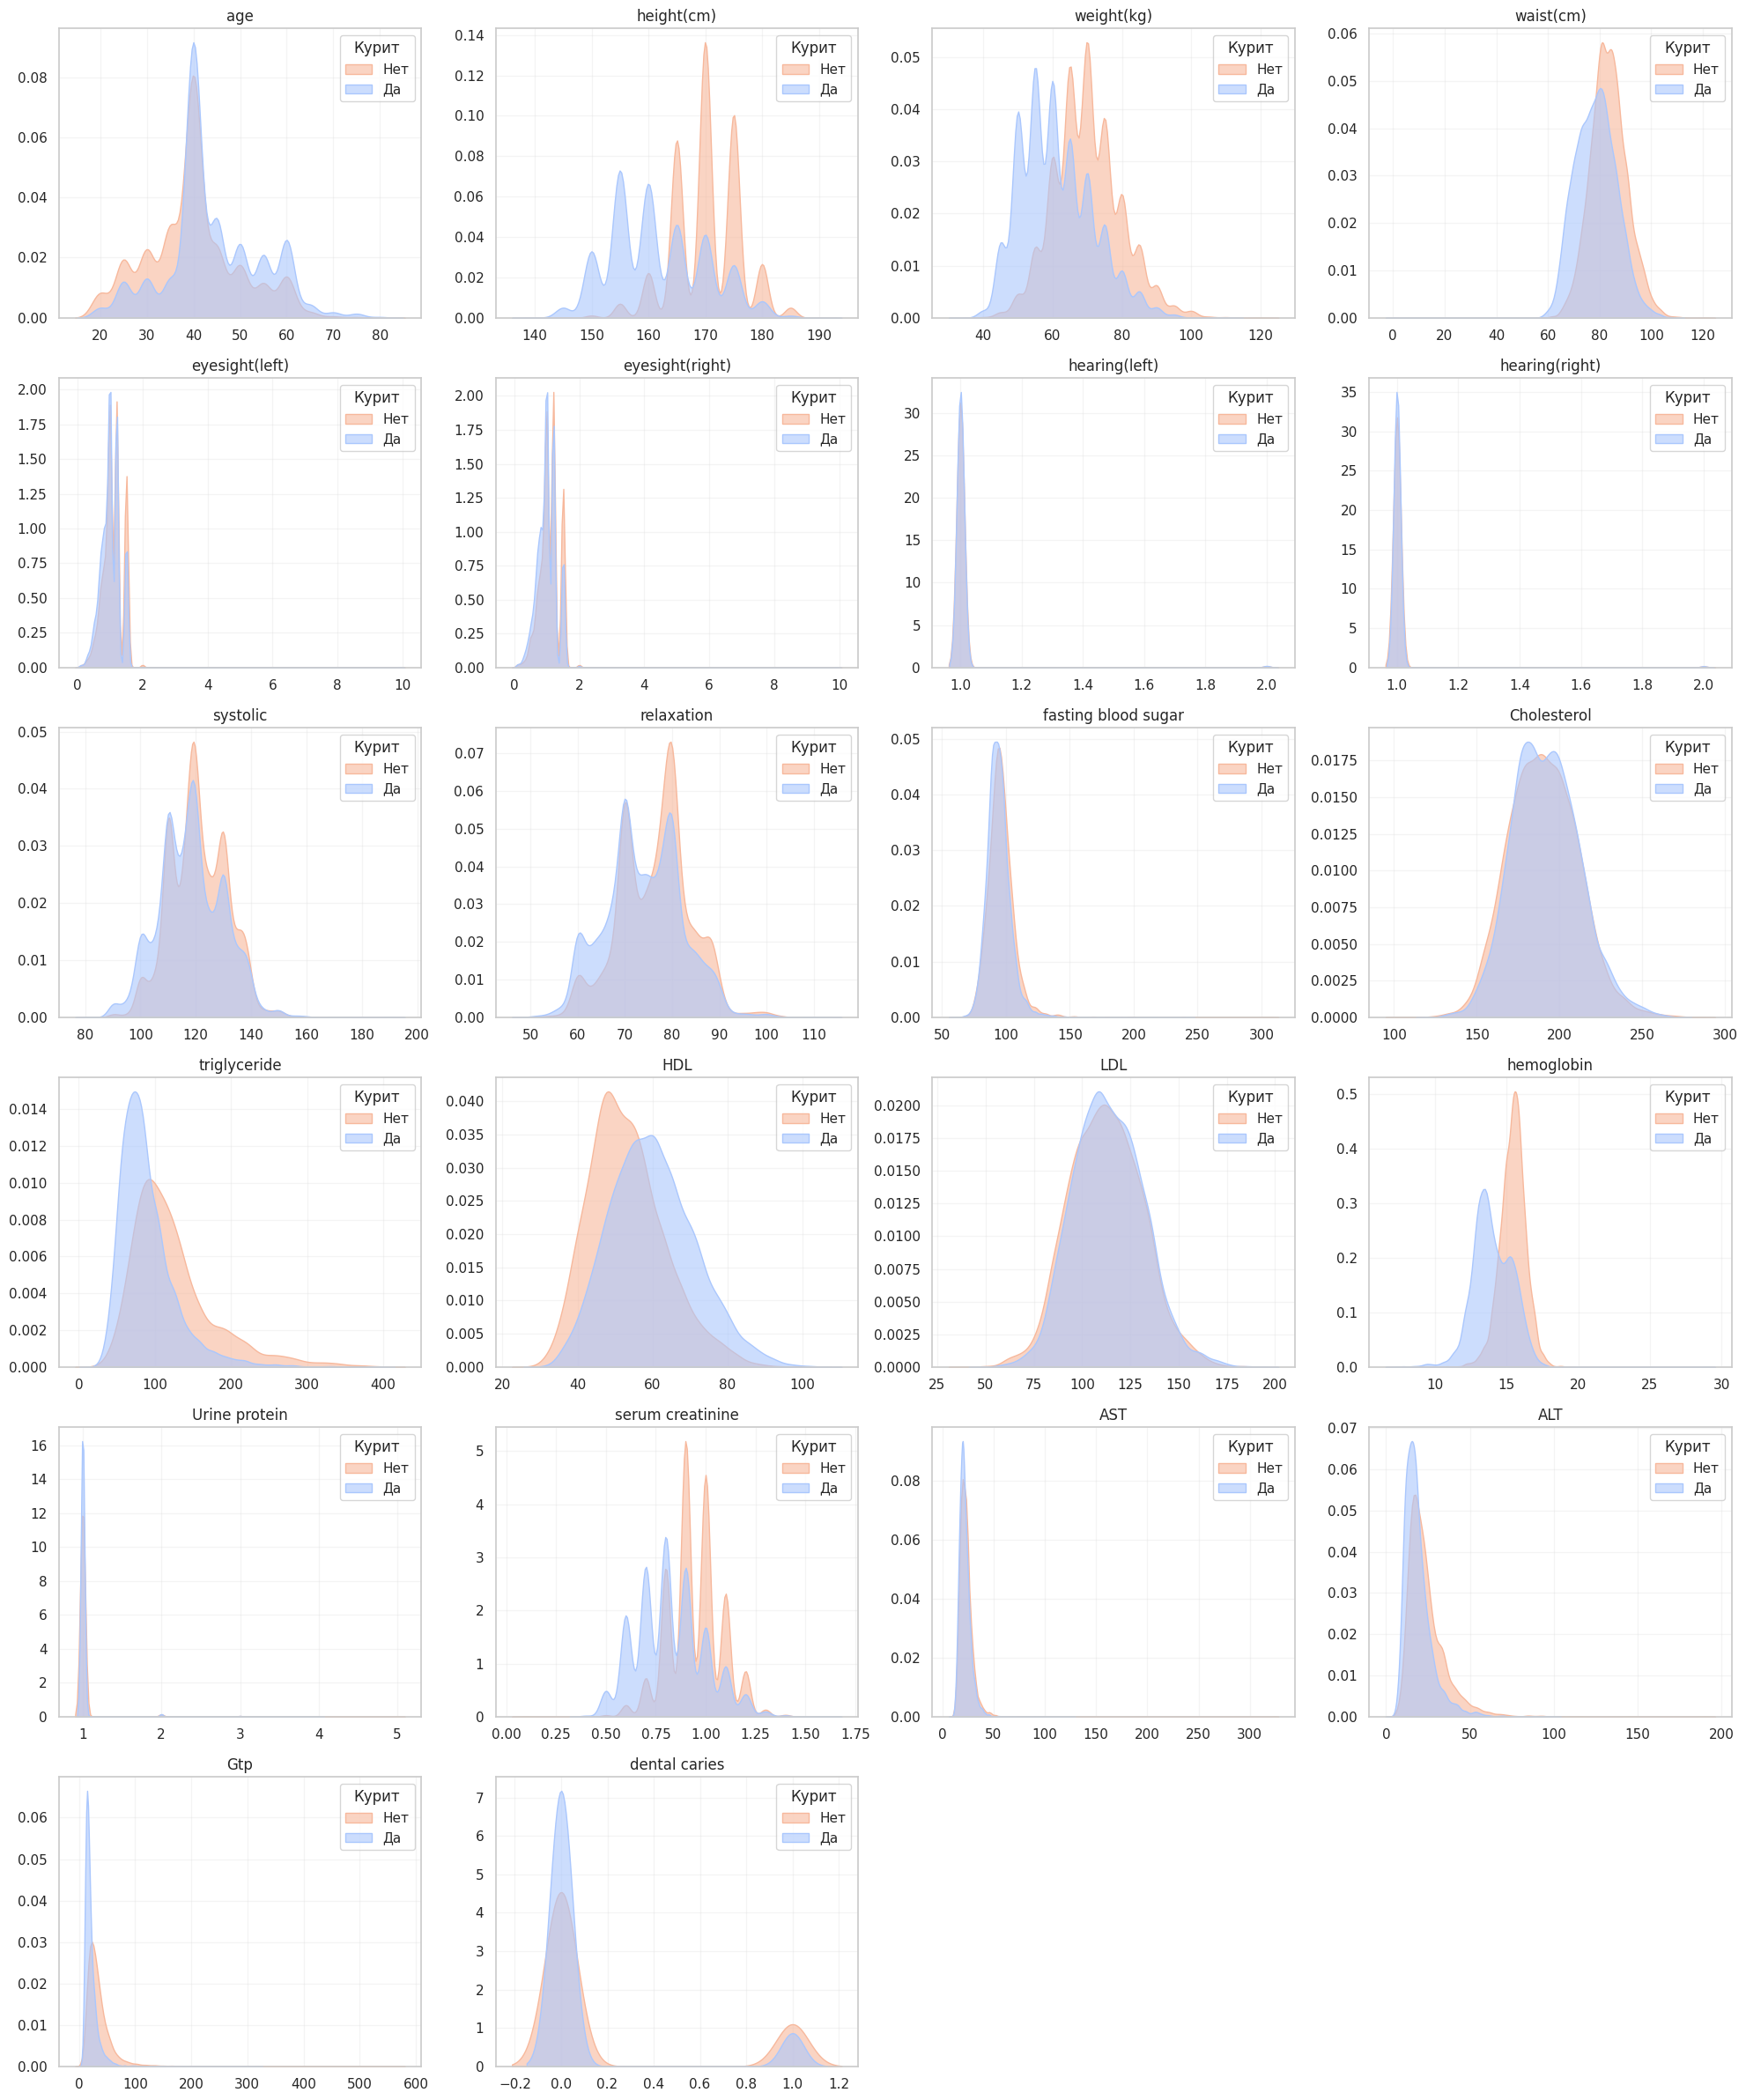

In [57]:
num_features = train_df.select_dtypes(include='number').drop(columns='smoking').columns

cols_per_row = 4
rows = math.ceil(len(num_features) / cols_per_row)

plt.figure(figsize=(cols_per_row * 5, rows * 4))

for idx, feature in enumerate(num_features, start=1):
    plt.subplot(rows, cols_per_row, idx)
    
    # Построение KDE по признаку для каждой группы 'smoking'
    sns.kdeplot(data=train_df, x=feature, hue='smoking', fill=True,
                common_norm=False, palette='coolwarm', alpha=0.6)
    
    plt.title(f'{feature}')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(alpha=0.2)
    plt.legend(title='Курит', labels=['Нет', 'Да'])

plt.tight_layout()
plt.show()

Вывод: данные подходят для обучения модели. Нет дубликатов, null-значений, мало сильно коррелирующих признаков. Однако в выборке некурящих значительно больше, в сравнении с курящими, что негативно может повлиять на результат обучения модели.

# Бэггинг

In [58]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from scipy.special import expit

class MyGradientBoostingClassifier:
    def __init__(self, n_trees=100, learning_rate=0.1, max_depth=3):
        self.n_trees = n_trees # количество деревьев
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.base_models = []
        self.initial_logit = None

    def fit(self, X, y):
        p = np.mean(y)
        self.initial_logit = np.log(p / (1 - p))

        logit_scores = np.full(y.shape, self.initial_logit)

        for _ in range(self.n_trees):
            p = expit(logit_scores)
            residual = y - p # градиент  log-loss

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)

            increment = tree.predict(X)
            logit_scores += self.learning_rate * increment

            self.base_models.append(tree)

    def predict_proba(self, X):
        logit_scores = np.full((X.shape[0],), self.initial_logit)

        for tree in self.base_models:
            logit_scores += self.learning_rate * tree.predict(X)
            
        p = expit(logit_scores)
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X = train_df.drop(columns=["smoking"]).values
y = train_df["smoking"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MyGradientBoostingClassifier(n_trees=99, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.7863333333333333
ROC AUC: 0.869853093755895


In [60]:
from sklearn.ensemble import GradientBoostingClassifier

sk_model = GradientBoostingClassifier(n_estimators=99, learning_rate=0.1, max_depth=3, random_state=42)
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_proba = sk_model.predict_proba(X_test)[:, 1]

print("Sklearn Accuracy:", accuracy_score(y_test, sk_pred))
print("Sklearn ROC AUC:", roc_auc_score(y_test, sk_proba))


Sklearn Accuracy: 0.8083333333333333
Sklearn ROC AUC: 0.8897957932465571


# Сравнение результатов работы алгоритмов градиентного бустинга.

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


X = train_df.drop(columns=["smoking"])
y = train_df["smoking"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Sklearn_GB': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, verbose=0)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }

    results.append(metrics)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AUC-ROC', ascending=False)
print(results_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4359, number of negative: 7641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363250 -> initscore=-0.561286
[LightGBM] [Info] Start training from score -0.561286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Самая лучшая = XGboost

# Подборка оптимальных параметров для XGBoost

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import optuna
import warnings
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

def tuning_function(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 80, 400),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 4.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "random_state": 42,
        "n_jobs": -1,
        "use_label_encoder": False,
        "eval_metric": "auc"
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_proba)

study = optuna.create_study(direction="maximize")
study.optimize(tuning_function, n_trials=50)

best_params = study.best_params
print("\nЛучшие параметры:")
print(pd.DataFrame(best_params.items(), columns=["Параметр", "Значение"]))

final_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)

y_test_probs = final_model.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_test_probs)
print(f"\nИтоговая метрика AUC-ROC: {final_auc:.5f}")



Лучшие параметры:
           Параметр    Значение
0      n_estimators  305.000000
1         max_depth    5.000000
2     learning_rate    0.081629
3         subsample    0.602763
4  colsample_bytree    0.610966
5             gamma    3.948720
6         reg_alpha    0.445548
7        reg_lambda    1.068554

Итоговая метрика AUC-ROC: 0.89706


In [63]:

X_test = test_df.drop(columns=["id"], errors="ignore")

test_proba = final_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "id": test_df["id"],
    "smoking": test_proba 
})

submission["smoking"] = submission["smoking"].round(6)

submission.to_csv("submission2.csv", index=False)


# Реализация метрик

In [64]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

def compute_accuracy(y_true, y_pred):
    return np.mean(np.asarray(y_true) == np.asarray(y_pred))


def compute_precision(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    return tp / (tp + fp) if (tp + fp) else 0.0


def compute_recall(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return tp / (tp + fn) if (tp + fn) else 0.0


def compute_f1(y_true, y_pred):
    p = compute_precision(y_true, y_pred)
    r = compute_recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) else 0.0


def compute_auc_roc(y_true, y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    idx = np.argsort(-y_score)
    sorted_y = y_true[idx]

    pos = np.sum(y_true == 1)
    neg = np.sum(y_true == 0)
    if pos == 0 or neg == 0:
        return 0.5

    tpr, fpr = [], []
    tp = fp = 0

    for label in sorted_y:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / pos)
        fpr.append(fp / neg)

    auc = 0.0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1]) / 2

    return auc


def compute_auc_pr(y_true, y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    idx = np.argsort(-y_score)
    sorted_y = y_true[idx]

    pos = np.sum(y_true == 1)
    if pos == 0:
        return 0.0

    tp = fp = 0
    prec, rec = [], []

    for label in sorted_y:
        if label == 1:
            tp += 1
        else:
            fp += 1
        prec.append(tp / (tp + fp))
        rec.append(tp / pos)

    auc = 0.0
    for i in range(1, len(prec)):
        auc += (rec[i] - rec[i - 1]) * (prec[i] + prec[i - 1]) / 2

    return auc


if __name__ == "__main__":
    y_true = np.array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0])
    y_pred = np.array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0])
    y_scores = np.array([0.1, 0.4, 0.9, 0.8, 0.35, 0.5, 0.2, 0.85, 0.45, 0.1])

    print("Accuracy (custom):", compute_accuracy(y_true, y_pred))
    print("Accuracy (sklearn):", accuracy_score(y_true, y_pred))

    print("Precision (custom):", compute_precision(y_true, y_pred))
    print("Precision (sklearn):", precision_score(y_true, y_pred))

    print("Recall (custom):", compute_recall(y_true, y_pred))
    print("Recall (sklearn):", recall_score(y_true, y_pred))

    print("F1-score (custom):", compute_f1(y_true, y_pred))
    print("F1-score (sklearn):", f1_score(y_true, y_pred))

    print("AUC-ROC (custom):", compute_auc_roc(y_true, y_scores))
    print("AUC-ROC (sklearn):", roc_auc_score(y_true, y_scores))

    print("AUC-PR (custom):", compute_auc_pr(y_true, y_scores))
    print("AUC-PR (sklearn):", average_precision_score(y_true, y_scores))


Accuracy (custom): 0.7
Accuracy (sklearn): 0.7
Precision (custom): 0.75
Precision (sklearn): 0.75
Recall (custom): 0.6
Recall (sklearn): 0.6
F1-score (custom): 0.6666666666666665
F1-score (sklearn): 0.6666666666666666
AUC-ROC (custom): 1.0
AUC-ROC (sklearn): 1.0
AUC-PR (custom): 0.8
AUC-PR (sklearn): 1.0
